In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import efficientnet
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
path = Path(".")
data_path = path / ".." / ".." / ".." / "Dataset" / "Sipakmed Dataset" / "wsi_dataset"
data_path.ls()

[PosixPath('../../../Dataset/Sipakmed Dataset/wsi_dataset/train'),
 PosixPath('../../../Dataset/Sipakmed Dataset/wsi_dataset/test')]

In [4]:
data_init = (ImageList.from_folder(data_path / "train")
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (966 items)
x: ImageList
Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [6]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=60.0, max_zoom=1.0)

In [7]:
def model_callback(model, model_name):
    return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

In [8]:
our_metrics = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
our_metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f44861c4c80>>,
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2),
 KappaScore(weights='quadratic')]

In [9]:
idxs = [[train_idx, val_idx] for train_idx, val_idx in skf.split(data_init.x.items, data_init.y.items)]

In [10]:
def get_fold_data(fold_idxs, img_size, bs=16):
    return (ImageList.from_folder(data_path / "train")
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=img_size)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

# Fold-1

In [11]:
fold_data = get_fold_data(idxs[0], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (772 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (194 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

In [12]:
learner = cnn_learner(fold_data, models.resnet101, metrics=our_metrics).to_fp16()
learner

Learner(data=ImageDataBunch;

Train: LabelList (772 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (194 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


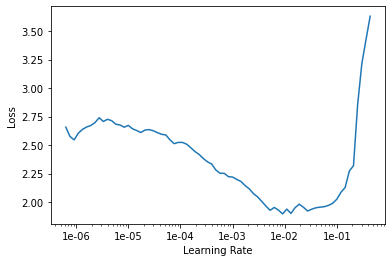

In [13]:
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(30, max_lr=slice(1.5e-03), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold1-stage1"))
learner.save("last-resnet101-sipak-multiclass-fold1-stage1")

Better model found at epoch 0 with accuracy value: 0.7164948582649231.
Better model found at epoch 1 with accuracy value: 0.8453608155250549.
Better model found at epoch 3 with accuracy value: 0.876288652420044.
Better model found at epoch 4 with accuracy value: 0.8917526006698608.
Better model found at epoch 5 with accuracy value: 0.8969072103500366.
Better model found at epoch 6 with accuracy value: 0.9175257682800293.
Better model found at epoch 9 with accuracy value: 0.9226804375648499.
Better model found at epoch 11 with accuracy value: 0.9484536051750183.
Better model found at epoch 13 with accuracy value: 0.9536082744598389.
Better model found at epoch 15 with accuracy value: 0.9587628841400146.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


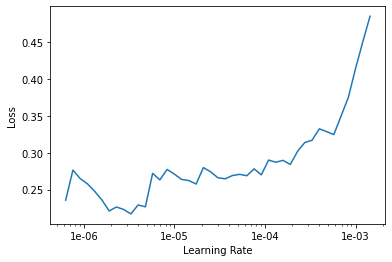

In [16]:
learner.load("best-resnet101-sipak-multiclass-fold1-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [17]:
learner.fit_one_cycle(30, max_lr=slice(1.5e-06), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold1-stage2"))
learner.save("last-resnet101-sipak-multiclass-fold1-stage2")

Better model found at epoch 0 with accuracy value: 0.9484536051750183.
Better model found at epoch 1 with accuracy value: 0.9587628841400146.
Better model found at epoch 13 with accuracy value: 0.9639175534248352.


# Fold-2

In [18]:
fold_data = get_fold_data(idxs[1], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


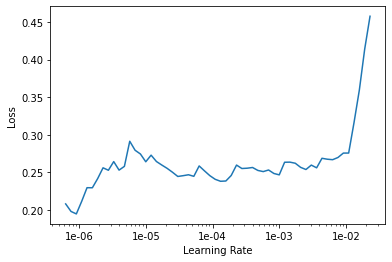

In [20]:
learner.load("best-resnet101-sipak-multiclass-fold1-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [21]:
learner.fit_one_cycle(30, max_lr=slice(6e-07), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold2-stage1"))
learner.save("last-resnet101-sipak-multiclass-fold2-stage1")

Better model found at epoch 0 with accuracy value: 0.9792746305465698.
Better model found at epoch 4 with accuracy value: 0.984455943107605.
Better model found at epoch 21 with accuracy value: 0.9896373152732849.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


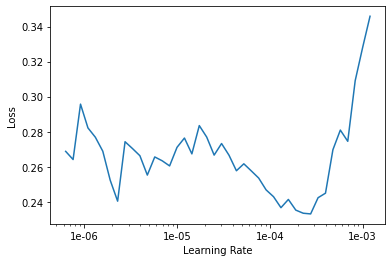

In [23]:
learner.load("best-resnet101-sipak-multiclass-fold2-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [24]:
learner.fit_one_cycle(30, max_lr=slice(1.8e-04), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold2-stage2"))
learner.save("last-resnet101-sipak-multiclass-fold2-stage2")

Better model found at epoch 0 with accuracy value: 0.9792746305465698.
Better model found at epoch 1 with accuracy value: 0.984455943107605.
Better model found at epoch 2 with accuracy value: 0.9896373152732849.


# Fold-3

In [25]:
fold_data = get_fold_data(idxs[2], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


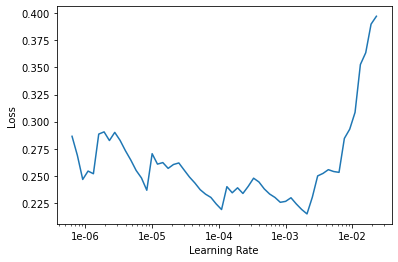

In [26]:
learner.load("best-resnet101-sipak-multiclass-fold2-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(30, max_lr=slice(1.2e-03), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold3-stage1"))
learner.save("last-resnet101-sipak-multiclass-fold3-stage1")

Better model found at epoch 0 with accuracy value: 0.9896373152732849.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


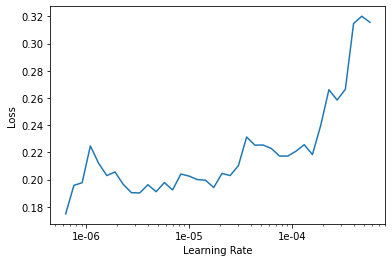

In [30]:
learner.load("best-resnet101-sipak-multiclass-fold3-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [31]:
learner.fit_one_cycle(30, max_lr=slice(6e-07), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold3-stage2"))
learner.save("last-resnet101-sipak-multiclass-fold3-stage2")

Better model found at epoch 0 with accuracy value: 0.9896373152732849.
Better model found at epoch 3 with accuracy value: 1.0.


# Fold-4

In [32]:
fold_data = get_fold_data(idxs[3], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


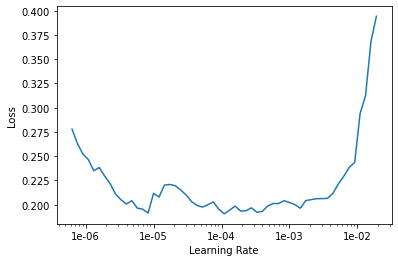

In [33]:
learner.load("best-resnet101-sipak-multiclass-fold3-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [34]:
learner.fit_one_cycle(30, max_lr=slice(3e-06), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold4-stage1"))
learner.save("last-resnet101-sipak-multiclass-fold4-stage1")

Better model found at epoch 0 with accuracy value: 0.9740932583808899.
Better model found at epoch 3 with accuracy value: 0.9792746305465698.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


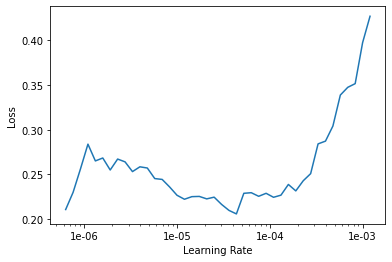

In [36]:
learner.purge()
learner.load("best-resnet101-sipak-multiclass-fold4-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [37]:
learner.fit_one_cycle(30, max_lr=slice(2.7e-05), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold4-stage2"))
learner.save("last-resnet101-sipak-multiclass-fold4-stage2")

Better model found at epoch 0 with accuracy value: 0.9740932583808899.
Better model found at epoch 3 with accuracy value: 0.9792746305465698.


# Fold-5

In [38]:
fold_data = get_fold_data(idxs[4], img_size=224, bs=16)
fold_data

ImageDataBunch;

Train: LabelList (773 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Valid: LabelList (193 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset/train;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


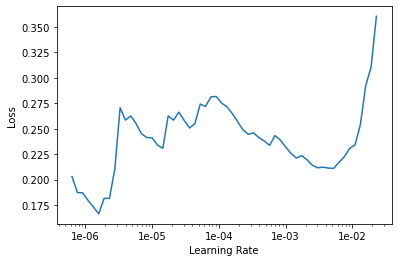

In [41]:
learner.purge()
learner.load("best-resnet101-sipak-multiclass-fold4-stage2")
learner = to_fp16(learner)
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [42]:
learner.fit_one_cycle(30, max_lr=slice(1e-06), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold5-stage1"))
learner.save("last-resnet101-sipak-multiclass-fold5-stage1")

Better model found at epoch 0 with accuracy value: 0.9948186278343201.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


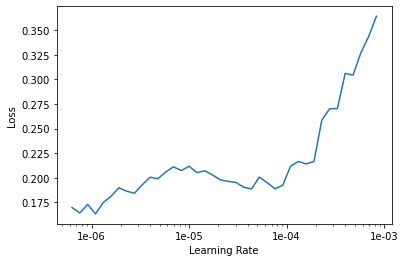

In [43]:
learner.load("last-resnet101-sipak-multiclass-fold5-stage1") # change to best if last not better
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [44]:
learner.fit_one_cycle(30, max_lr=slice(9e-07), callbacks=model_callback(learner, "best-resnet101-sipak-multiclass-fold5-stage2"))
learner.save("last-resnet101-sipak-multiclass-fold5-stage2")

Better model found at epoch 0 with accuracy value: 0.9948186278343201.


# Exporting the final model

In [45]:
learner.freeze()
learner.export("best-resnet101-sipak-multiclass.pkl")

# Testing on 30 images (in valid folder)

In [46]:
all_data = (ImageList.from_folder(data_path)
            .split_by_folder(train="train", valid="test")
            .label_from_folder()
            .transform(None, size=224)
            .databunch(bs=1)
            .normalize(imagenet_stats))
all_data

ImageDataBunch;

Train: LabelList (966 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset;

Valid: LabelList (29 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate,normal_Superficial-Intermediate
Path: ../../../Dataset/Sipakmed Dataset/wsi_dataset;

Test: None

In [47]:
imgs, labels = all_data.valid_ds.x, all_data.valid_ds.y
binary_classes = ["Abnormal", "Benign", "Normal"]

In [48]:
def get_label(label):
    if "abnormal" in label:
        return "Abnormal"
    elif "normal" in label:
        return "Normal"
    elif "benign" in label:
        return "Benign"

y_preds, y_true = [], []
for img, label in zip(imgs, labels):
    y_true.append(get_label(str(label)))
    y_preds.append(get_label(str(learner.predict(img)[0])))

In [49]:
multi_y_preds, multi_y_true = [], []
for img, label in zip(imgs, labels):
    multi_y_true.append(str(label))
    multi_y_preds.append(str(learner.predict(img)[0]))

In [50]:
multi_classes = all_data.classes
multi_classes

['abnormal_Dyskeratotic',
 'abnormal_Koilocytotic',
 'benign_Metaplastic',
 'normal_Parabasal',
 'normal_Superficial-Intermediate']

In [51]:
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

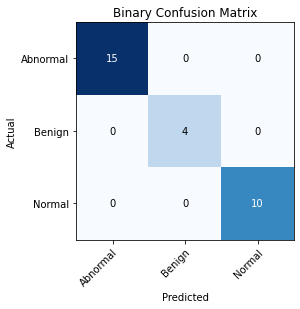

In [52]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_preds, classes=binary_classes, title='Binary Confusion Matrix')
plt.show()

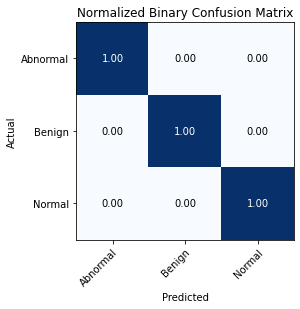

In [53]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_preds, normalize=True, classes=binary_classes, 
                      title='Normalized Binary Confusion Matrix')
plt.show()

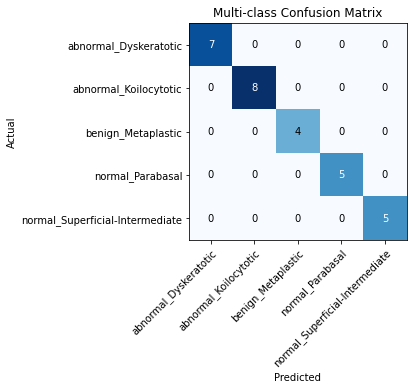

In [54]:
# Plot normalized confusion matrix
plot_confusion_matrix(multi_y_true, multi_y_preds, normalize=False, classes=multi_classes, 
                      title='Multi-class Confusion Matrix')
plt.show()

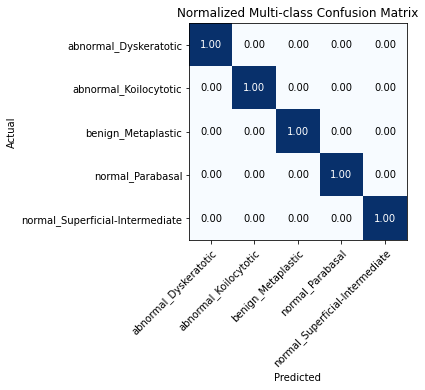

In [55]:
# Plot normalized confusion matrix
plot_confusion_matrix(multi_y_true, multi_y_preds, normalize=True, classes=multi_classes, 
                      title='Normalized Multi-class Confusion Matrix')
plt.show()

# Results (first save results.csv)

In [56]:
def compute_results(fname):
    df = pd.read_csv(fname)
    print(df)
    print("*-*" * 10)
    print("Results :-")
    mean_df = np.mean(df, axis=0)
    mean_error_df = np.mean(np.abs(mean_df - df), axis=0)
    for col, mean, error in zip(list(df.columns), list(mean_df.values), list(mean_error_df.values)):
        print(f"{col.capitalize()} : {mean * 100:.4f} % | { error * 100:.4f} %")

compute_results("results.csv")

   accuracy  precision    recall    f_beta  kappa_score
0  0.963918   0.960286  0.967327  0.965311     0.952829
1  0.989637   0.992282  0.987455  0.988328     0.979747
2  1.000000   1.000000  1.000000  1.000000     1.000000
3  0.979275   0.979630  0.984722  0.983495     0.972813
4  0.994819   0.996364  0.995745  0.995843     0.998471
*-**-**-**-**-**-**-**-**-**-*
Results :-
Accuracy : 98.5530 % | 1.1147 %
Precision : 98.5712 % | 1.2604 %
Recall : 98.7050 % | 0.8820 %
F_beta : 98.6595 % | 0.9754 %
Kappa_score : 98.0772 % | 1.4771 %
